In [325]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pprint import pprint
import spacy
from spacy.tokenizer import _get_regex_pattern
import nltk
from nltk.corpus import stopwords
import re
from spacy.matcher import Matcher
import spacy
from spacymoji import Emoji
from collections import Counter
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
import string
import networkx as nx
from normalise import normalise
from sklearn.feature_extraction.text import CountVectorizer

ModuleNotFoundError: No module named 'normalise'

## Tinder Swindler 100k Tweets

In [87]:
# load the dataset
file = './TinderSwindlerVersion2.csv'
df = pd.read_csv(file)

In [88]:
df.head(10)

,user_name,user_location,user_created,user_followers,user_verified,date,text,source,is_retweet
0,globalnode.saito 🟥🐳🐈‍⬛,Travelling the World on Web3,2009-06-03 20:18:22+00:00,768,False,2022-02-09 17:09:22+00:00,"@T1gmee Tinder Swindler, off Netflix",Twitter for iPhone,False
1,Ungovernable 🇧🇮,NaN,2011-09-04 22:46:26+00:00,385,False,2022-02-09 17:09:18+00:00,"#tinderswindler , basically homeboy got away w...",Twitter for iPhone,False
2,Adefolake,NaN,2009-06-02 14:18:44+00:00,1994,False,2022-02-09 17:09:17+00:00,Not the tinder swindler becoming a TIk Tok sta...,Twitter for iPhone,False
3,✧ ☽,Noord-Brabant,2012-02-12 07:35:26+00:00,336,False,2022-02-09 17:09:07+00:00,Why isn’t Shimon Hayut in jail ????? #thetinde...,Twitter for iPhone,False
4,chivo. 🥶,PG/MD,2010-03-22 21:23:17+00:00,1046,False,2022-02-09 17:09:06+00:00,the tinder swindler a sick nigga 😂😂,Twitter Web App,False
5,kira,"Toronto, Ontario",2010-07-02 12:50:53+00:00,362,False,2022-02-09 17:09:03+00:00,No those women on the Tinder swindler pissed m...,Twitter for iPhone,False
6,fogmistress698,NaN,2020-05-05 08:47:57+00:00,210,False,2022-02-09 17:08:55+00:00,This manipulation is how scammers pull you in ...,Twitter Web App,False
7,melraunch,"East, England",2019-05-24 23:18:01+00:00,3268,False,2022-02-09 17:08:45+00:00,@robertstweets1 @DistantFixed I waited for him...,Twitter for iPhone,False
8,Pamela Power,"Johannesburg, South Africa",2009-07-10 12:51:24+00:00,6306,False,2022-02-09 17:08:41+00:00,Hmmm...he's like the #tinderswindler https://t...,Twitter for Android,False
9,CaliMcCormac,NaN,2022-02-09 16:48:06+00:00,0,False,2022-02-09 17:08:40+00:00,Wow just watching the Twitter Swindler and it ...,Twitter for iPhone,False


### Data Cleansing

In [89]:
df.isna().sum()

user_name             5
user_location     18481
user_created          0
user_followers        0
user_verified         0
date                  0
text                  0
source                0
is_retweet            0
dtype: int64

In [90]:
df["user_name"].fillna('unknown', inplace=True)
df["user_location"].fillna('unknown', inplace=True)

In [91]:
# Remove urls from tweets
df.text = df.text.apply(lambda text: re.sub(r'http\S+|http', '', text))

In [92]:
df = df[df.is_retweet != True]

In [93]:
df.describe(include= "O").T

,count,unique,top,freq
user_name,76213,49767,.,196
user_location,76213,17911,unknown,18485
user_created,76213,54501,2020-10-06 00:15:38+00:00,160
date,76213,70999,2022-02-07 21:13:06+00:00,5
text,76213,73948,The Tinder Swindler,69
source,76213,210,Twitter for iPhone,47828


In [94]:
df_sample = df.sample(10000)

### Load Spacy and init stop words

In [95]:
nltk.download('stopwords')

nlp = spacy.load('en_core_web_lg')
nlp.add_pipe("emoji", first=True)

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add patterns for hashtags and in-word hyphens
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderkneis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [342]:
# extend stop words if needed
stop_words.extend(["\n", "\n\n"])

In [296]:
no_stop_words = [
    'not'
]

for w in no_stop_words:
    nlp.vocab[w].is_stop = False

#### Create docs via spacy
Follow along [this](https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a) guide for more details about each single step

In [330]:
# custom extended abbreviations
custom_abbreviations = {"bdrm": "bedroom"}

def normalize(text):
    # choosing BrE variety here since majority of posts are from the UK
        try:
            return ' '.join(normalise(text, variety="BrE", user_abbrevs=custom_abbreviations, verbose=False))
        except:
            return text

In [332]:
df_sample.text.apply(normalize)

61064                 the tinder swindler docu was W I L D
52386    This song Lives Rent Free In My Head😂‼️❤️\n\n#...
38472    #tinderswindler a guys gotta do what a guys go...
1639     @MattToshi @JohnForEther @thecryptomonk It's t...
844      #tinderswindler Cecile: "I cant understand how...
                               ...                        
35306    I decided to give it a shot. Watching... #tind...
27881           The Tinder Swindler BRRROROOOO WHATAFAAAAK
14454    Nah this is the type of finesse niggas want to...
7710     After watching Tinder Swindler I realized I ha...
9664     Okay so.. we just fly and go to someone house ...
Name: text, Length: 10000, dtype: object

In [333]:
# create docs list with nlp
docs = [d for d in nlp.pipe(df_sample.text, n_process=6)]

In [334]:
def remove_stop_words(doc):
    return [t for t in doc if not t.is_stop]

In [335]:
# python based removal
def remove_punct(doc):
    return [t for t in doc if t.text not in string.punctuation]

In [356]:
def lemmatize(doc):
    return ' '.join([t.lemma_ for t in doc])

In [357]:
def preprocess_text(doc):
        removed_punct = remove_punct(doc)
        removed_stop_words = remove_stop_words(removed_punct)
        return lemmatize(removed_stop_words)

In [360]:
pre_proccesed_texts = [preprocess_text(doc) for doc in docs]

In [361]:
pre_proccesed_texts[:5]

['tinder swindler docu W l d',
 'song live rent Free Head 😂 ‼️ ❤️ \n\n #taooma #asuustrike #tinderswindler',
 '#tinderswindler guy get to guy get to secure bag 😭 hold Simon \n\n P …',
 '@MattToshi @johnforether @thecryptomonk tinder swindler',
 '#tinderswindler cecile not understand fucking evil \n not understand fuck stupid']

In [362]:
doc_vectors = [doc.vector for doc in docs]

In [354]:
docs[0]

the tinder swindler docu was W I L D

### Get Hashtags and Emoji

In [100]:
matcher = Matcher(nlp.vocab)
pattern = [{"TEXT": {"REGEX": "^#\w+|\w+-\w+"}}]
matcher.add('HASHTAG', [pattern])

def getHashtags(doc):
    matches = matcher(doc)
    hashtags = []
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        text = re.sub('[^A-Za-z0-9_-]+', '', span.text)
        hashtags.append(text)
    return hashtags

# getHashtags(docs[15])
# >>> ['tinderswindler']

In [101]:
# create list of hastags
hashtags = [item for sublist in list(getHashtags(doc) for doc in docs) for item in sublist]

In [258]:
counter = Counter()

for tag in hashtags:
    counter[tag] += 1

top_15_hashtags = counter.most_common(15)

In [261]:
df_hashtags = pd.DataFrame.from_records(top_15_hashtags, columns =['hashtag', 'count'])

In [262]:
df_hashtags

,hashtag,count
0,tinderswindler,2071
1,TheTinderSwindler,1418
2,TinderSwindler,363
3,Netflix,80
4,simonleviev,28
5,TindlerSwindler,18
6,thetinderswindler,16
7,netflix,13
8,Tinder,13
9,Tinderswindler,12


In [263]:
def getEmoji(doc):
    emojis = set()
    if doc._.has_emoji:
        for emoji in doc._.emoji:
            emojis.add((emoji[0],emoji[2])) 

    return emojis

In [264]:
# create list of emojis
emojis = [item for sublist in list(getEmoji(doc) for doc in docs) for item in sublist]

In [265]:
counter = Counter()

for emoji in emojis:
    counter[emoji] += 1

top_15_emoji = (counter.most_common(15))

In [266]:
top_15_emoji

[(('😂', 'face with tears of joy'), 650),
 (('😭', 'loudly crying face'), 435),
 (('🤣', 'rolling on the floor laughing'), 310),
 (('🤯', 'exploding head'), 145),
 (('😳', 'flushed face'), 106),
 (('💀', 'skull'), 89),
 (('😩', 'weary face'), 73),
 (('😅', 'grinning face with sweat'), 56),
 (('👀', 'eyes'), 55),
 (('🥴', 'woozy face'), 52),
 (('😱', 'face screaming in fear'), 50),
 (('🚩', 'triangular flag'), 37),
 (('🤔', 'thinking face'), 30),
 (('🔥', 'fire'), 28),
 (('🥺', 'pleading face'), 24)]

In [228]:
flatted_emojis = []

for emoji in top_15_emoji:
    flatted_emoji = []
    for entry in emoji:
        if hasattr(entry, '__iter__'):
            for i in entry:
                flatted_emoji.append(i)
        else:
            flatted_emoji.append(entry)
    flatted_emojis.append(flatted_emoji)

print(flatted_emojis)
    
   


[['😂', 'face with tears of joy', 650], ['😭', 'loudly crying face', 435], ['🤣', 'rolling on the floor laughing', 310], ['🤯', 'exploding head', 145], ['😳', 'flushed face', 106], ['💀', 'skull', 89], ['😩', 'weary face', 73], ['😅', 'grinning face with sweat', 56], ['👀', 'eyes', 55], ['🥴', 'woozy face', 52], ['😱', 'face screaming in fear', 50], ['🚩', 'triangular flag', 37], ['🤔', 'thinking face', 30], ['🔥', 'fire', 28], ['🥺', 'pleading face', 24]]


In [229]:
# create DataFrame using data
df_emoji = pd.DataFrame.from_records(flatted_emojis, columns =['emoji',"desc", 'count'])

In [230]:
df_emoji

,emoji,desc,count
0,😂,face with tears of joy,650
1,😭,loudly crying face,435
2,🤣,rolling on the floor laughing,310
3,🤯,exploding head,145
4,😳,flushed face,106
5,💀,skull,89
6,😩,weary face,73
7,😅,grinning face with sweat,56
8,👀,eyes,55
9,🥴,woozy face,52


### First explorative Analysis

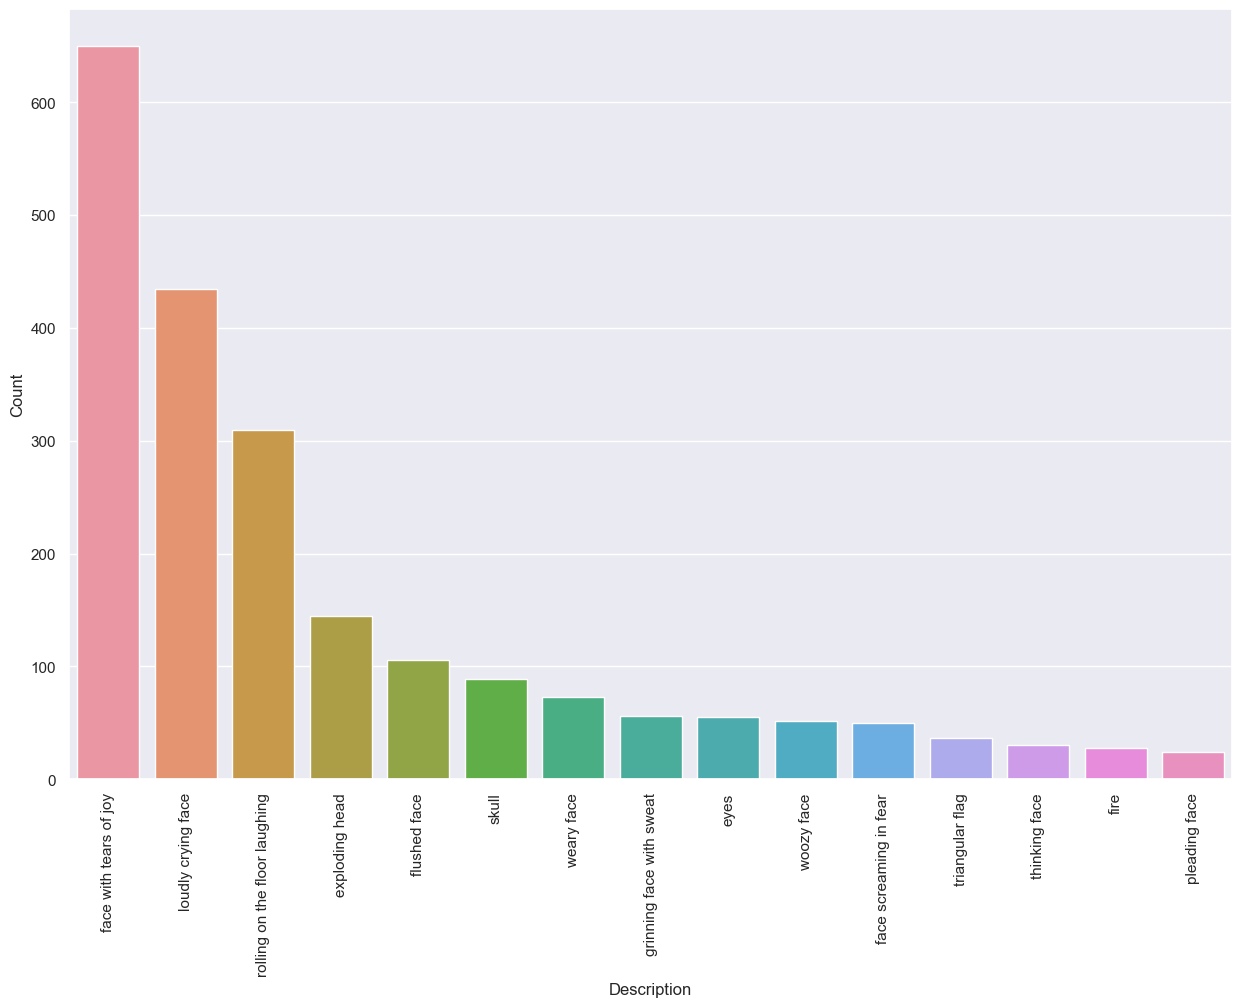

In [254]:
from pathlib import Path
import matplotlib as mpl

# fpath = Path(mpl.get_data_path(), "/System/Library/Fonts/Apple Color Emoji.ttc")

plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
# sns.set_style({'font.family': 'Apple Color Emoji'})
ax = sns.barplot(x="desc",y="count", data=df_emoji)
ax.set_xlabel("Description")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


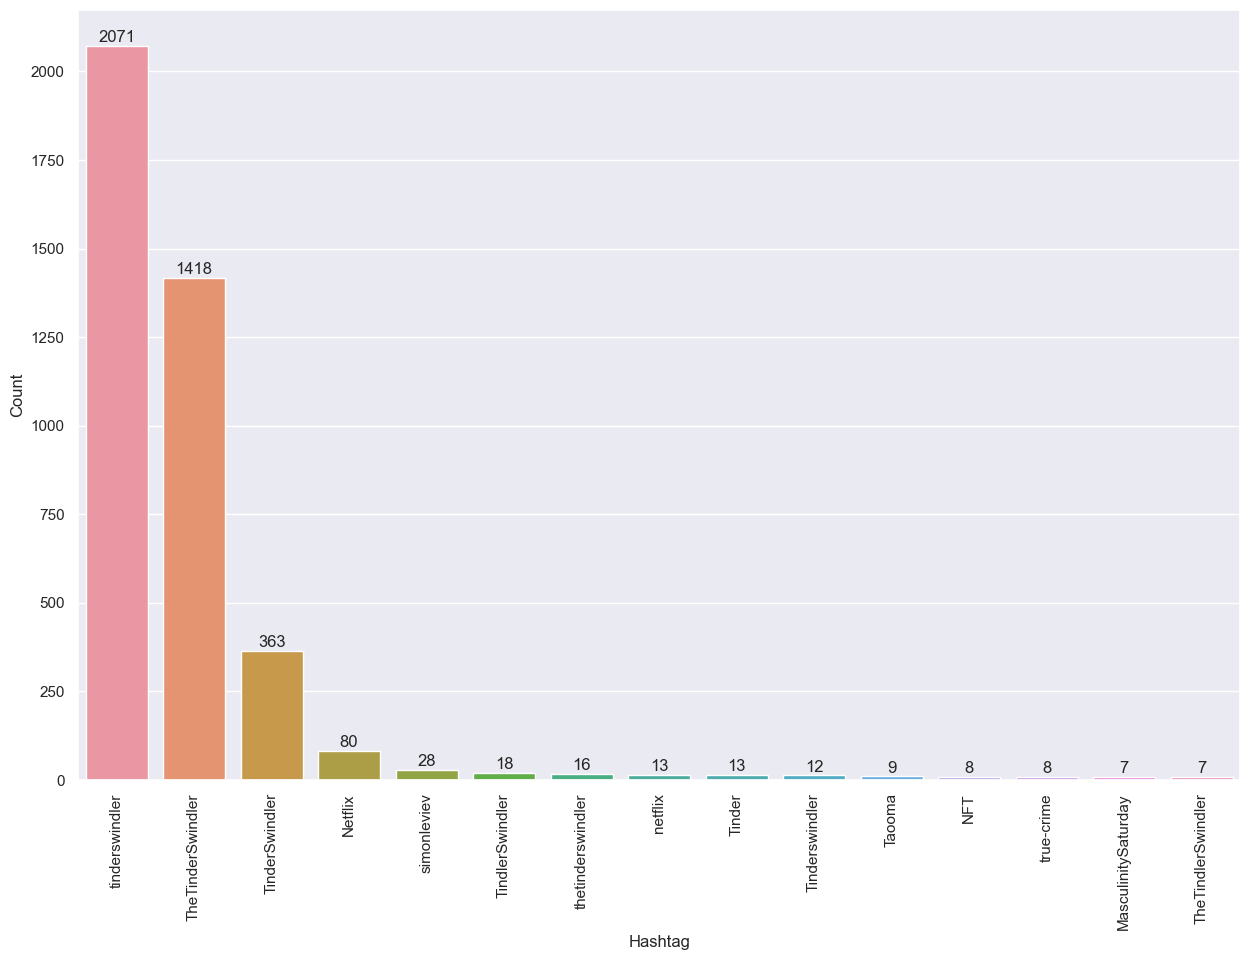

In [276]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="hashtag",y="count", data=df_hashtags)


for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


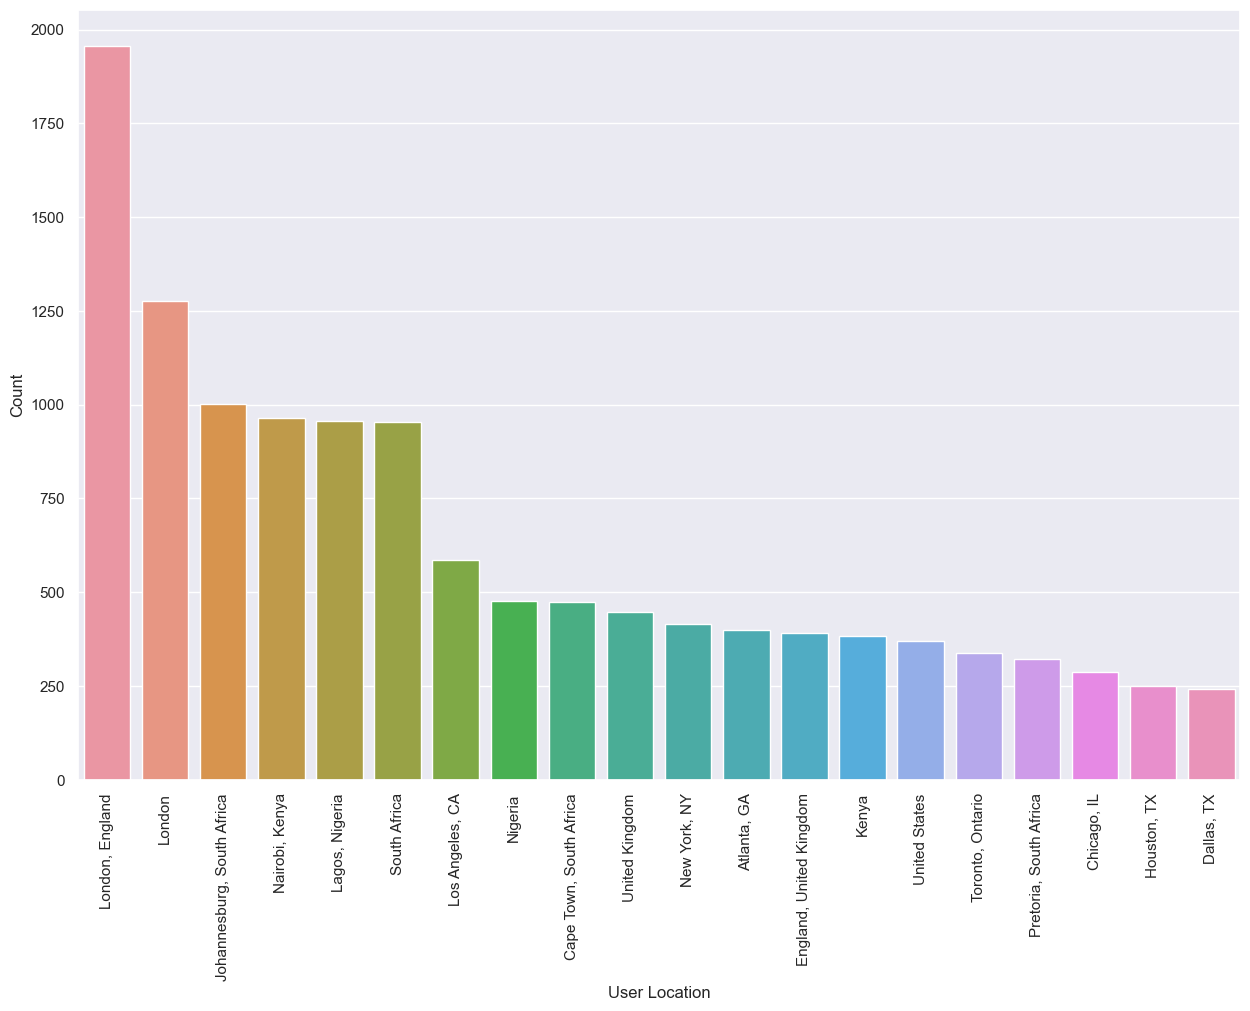

In [108]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="user_location", data=df[df["user_location"] != "unknown"], order=df[df["user_location"] != "unknown"]['user_location'].value_counts().index[0:20])
ax.set_xlabel("User Location")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)

In [109]:
df['datetime_date'] = pd.to_datetime(df['date']).dt.date

In [110]:
df_datecount = df.groupby(by="datetime_date")['datetime_date'].count().reset_index(name="count")

In [111]:
df_datecount

,datetime_date,count
0,2022-02-01,80
1,2022-02-02,3130
2,2022-02-03,6725
3,2022-02-04,9080
4,2022-02-05,13420
5,2022-02-06,14831
6,2022-02-07,11798
7,2022-02-08,11042
8,2022-02-09,6107


Text(0.5, 0, 'Date')

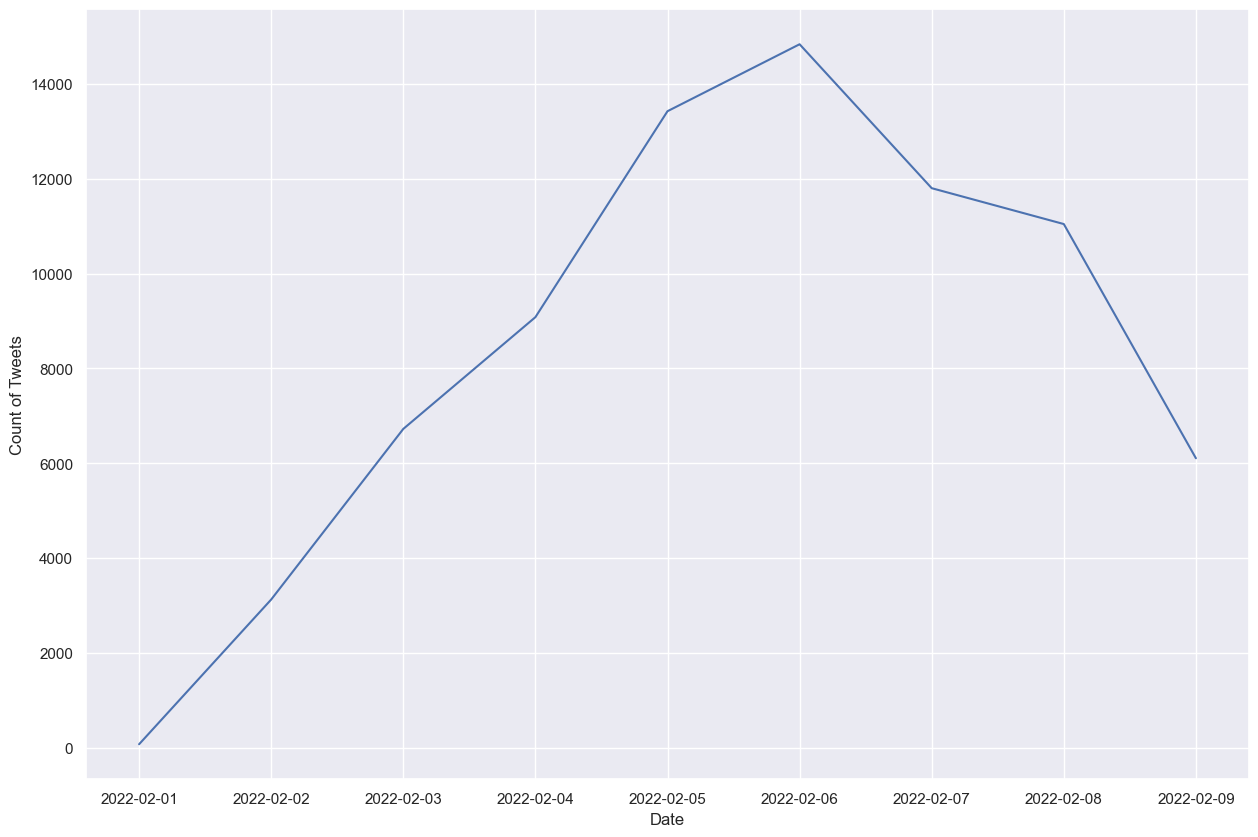

In [112]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_datecount,x=df_datecount["datetime_date"], y=df_datecount['count'].value_counts().index)
ax.set_ylabel("Count of Tweets")
ax.set_xlabel("Date")

The film was released on Netflix on February 2, 2022

### Preprocessing

### Document Term Matrix

In [257]:
# Count Vectorizer
vect = CountVectorizer(stop_words=stop_words)  
vects = vect.fit_transform(df_sample.text)

# Select the first five rows from the data set
td = pd.DataFrame(vects.todense()).iloc[:9]  
td.columns = vect.get_feature_names_out()
term_document_matrix = td.T
term_document_matrix.columns = ['Doc '+str(i) for i in range(1, 10)]
term_document_matrix['total_count'] = term_document_matrix.sum(axis=1)

# Top 25 words 
term_document_matrix = term_document_matrix.sort_values(by ='total_count',ascending=False)[:25] 

# Print the first 10 rows 
print(term_document_matrix.drop(columns=['total_count']).head(10))

                Doc 1  Doc 2  Doc 3  Doc 4  Doc 5  Doc 6  Doc 7  Doc 8  Doc 9
tinderswindler      0      1      1      0      1      0      1      0      1
simon               0      0      1      0      0      1      0      0      1
swindler            1      0      0      1      0      0      0      1      0
tinder              1      0      0      1      0      0      0      1      0
cant                0      0      0      0      2      0      0      0      0
gotta               0      0      2      0      0      0      0      0      0
someone             0      0      0      0      2      0      0      0      0
understand          0      0      0      0      2      0      0      0      0
fucking             0      0      0      0      2      0      0      0      0
guys                0      0      2      0      0      0      0      0      0


<AxesSubplot:>

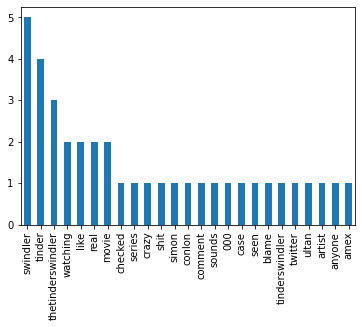

In [ ]:
term_document_matrix['total_count'].plot.bar()

### Cosine Similarity

In [ ]:
similarity = cosine_similarity(doc_vectors)

In [ ]:
similarity[similarity < 0.95] = 0

In [ ]:
pprint(similarity)

array([[1.0000004, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.0000001, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.9999996, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.0000001,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.0000001]], dtype=float32)


In [ ]:
G = nx.from_numpy_array(similarity)


KeyboardInterrupt: 

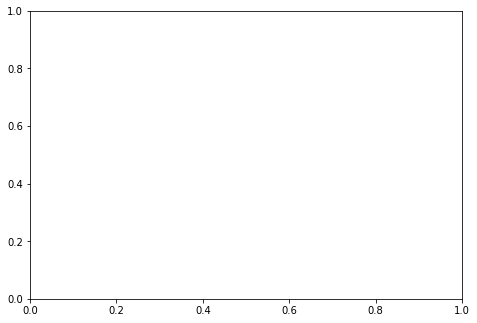

In [ ]:
nx.draw(G)